## Regresión Lineal con Cross-Validation 

Esta práctica muestra cómo hacer una validación cruzada (CV) con regresión lineal como ejemplo. Utilizaremos principalmente `sklearn` para hacer la validación cruzada.

Desarrollaremos las siguientes partes:
0. Experimentos para comprender el sobreajuste
1. Construyendo un modelo de regresión lineal sin validación cruzada
2. Problemas en el enfoque actual
3. Validación cruzada: un resumen rápido
4. Validación cruzada en `sklearn`:
     - 4.1 K-fold CV 
     - 4.2 Ajuste de hiperparámetros con CV


## 0. Experimentos para comprender el sobreajuste

En esta sección, repasemos rápidamente algunos experimentos para comprender cómo se ve el sobreajuste. Realizaremos algunos experimentos usando regresión polinómica.

In [1]:
# importamos las librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # suprimir advertencias
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# cargamos  Housing.csv y vemos las caracteristicas de los datos
housing = pd.read_csv('Housing.csv')
housing.head()

price  area  bedrooms  ...  parking  prefarea furnishingstatus
0  13300000  7420         4  ...        2       yes        furnished
1  12250000  8960         4  ...        3        no        furnished
2  12250000  9960         3  ...        2       yes   semi-furnished
3  12215000  7500         4  ...        3       yes        furnished
4  11410000  7420         4  ...        2        no        furnished

[5 rows x 13 columns]

In [3]:
# Número de observaciones
len(housing.index)

545

Para el primer experimento, haremos una regresión con solo una característica. Filtremos los datos para que solo contengan `area` y` price`.

In [4]:
# filtramos solo 'area' y 'price'
df = housing.loc[:, ['area', 'price']]
df.head()

area     price
0  7420  13300000
1  8960  12250000
2  9960  12250000
3  7500  12215000
4  7420  11410000

In [5]:
# Reescalamos ambas variables entre 0 y 1
df_columns = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

# renombrar columnas (ya que ahora es un np array)
df = pd.DataFrame(df)
df.columns = df_columns

df.head()

area     price
0  0.396564  1.000000
1  0.502405  0.909091
2  0.571134  0.909091
3  0.402062  0.906061
4  0.396564  0.836364

In [6]:
# visualizamos los datos en un diagrama de dispersión
sns.regplot(x="area", y="price", data=df, fit_reg=False)

In [7]:
# particionamos en train y test
df_train, df_test = train_test_split(df, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 10)
print(len(df_train))
print(len(df_test))

381
164


In [0]:
# dividido en X e y para los conjuntos de entrenamiento y test
# se requiere remodelación ya que sklearn requiere que los datos estén en forma
# (n, 1), no como una serie de forma (n,)
X_train = df_train['area']
X_train = X_train.values.reshape(-1, 1)
y_train = df_train['price']

X_test = df_test['area']
X_test = X_test.values.reshape(-1, 1)
y_test = df_test['price']

### Regresión polinómica

Ya sabes regresión lineal simple:

$y = w_0 + w_1 x_1$

En regresión polinómica de grado $ K $, ajustamos una curva de la forma:

$y = w_0 + w_1 x_1 + w_2x_1^2 + w_3x_1^3 ... + w_Kx_1^K$

En el siguiente experimento, probaremos polinomios de diversos grados en los datos housing y comparamos su rendimiento en entrenamiento y test.

En sklearn, las características polinómicas se pueden generar utilizando la clase `PolynomialFeatures`. Además, para realizar 'LinearRegression' y 'PolynomialFeatures' en conjunto, usaremos el módulo 'sklearn_pipeline': básicamente crea las características y alimenta la salida al modelo (en esa secuencia).


In [9]:
len(X_train)

381

Ahora haremos predicción de las etiquetas (tanto para los conjuntos de entrenamiento como de prueba) y almacenemos las predicciones en una tabla. Cada fila de la tabla es un punto de datos, cada columna tiene un valor de $ n $ (grado).

<table style="width:100%">
  <tr>
    <th>   </th>
    <th>degree-1</th>
    <th>degree-2</th> 
    <th>degree-3</th>
    <th>...</th>
    <th>degree-n</th>
  </tr>
  <tr>
    <th>x1</th>
  </tr>
  <tr>
    <th>x2</th>
  </tr>
   <tr>
    <th>x3</th>
    </tr>
    <tr>
    <th>...</th>
    </tr>
    <tr>
    <th>xn</th>
    </tr>
</table>

In [0]:
# fit multiple polynomial features
degrees = [1, 2, 3, 6, 10, 20]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)
    

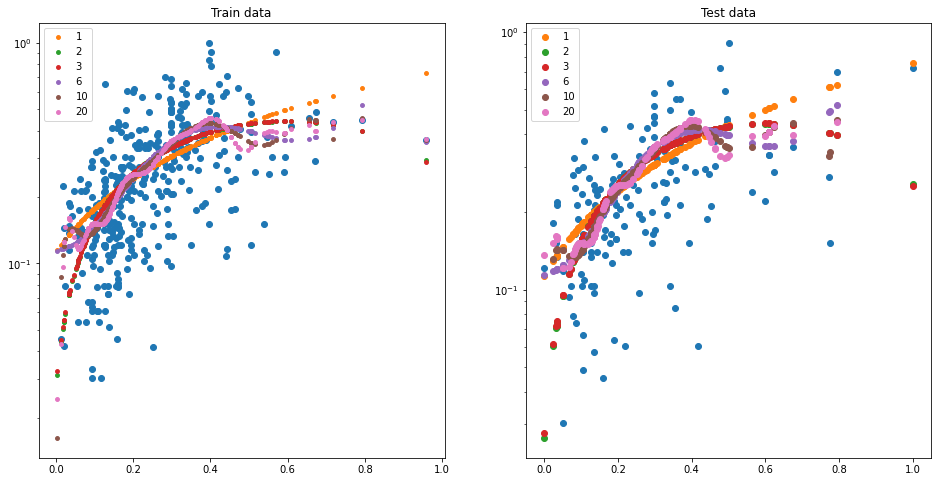

In [11]:
# visualise train and test predictions
# note that the y axis is on a log scale

plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

In [12]:
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

R-squared values: 

Polynomial degree 1: train score=0.29, test score=0.25
Polynomial degree 2: train score=0.34, test score=0.22
Polynomial degree 3: train score=0.34, test score=0.22
Polynomial degree 6: train score=0.36, test score=0.11
Polynomial degree 10: train score=0.37, test score=-108.76
Polynomial degree 20: train score=0.38, test score=-297146555772.27


## 1. Construyendo un modelo sin validación cruzada



In [13]:
# data preparation

# list of all the "yes-no" binary categorical variables
# we'll map yes to 1 and no to 0
binary_vars_list =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# defining the map function
def binary_map(x):
    return x.map({'yes': 1, "no": 0})

# applying the function to the housing variables list
housing[binary_vars_list] = housing[binary_vars_list].apply(binary_map)
housing.head()

price  area  bedrooms  ...  parking  prefarea  furnishingstatus
0  13300000  7420         4  ...        2         1         furnished
1  12250000  8960         4  ...        3         0         furnished
2  12250000  9960         3  ...        2         1    semi-furnished
3  12215000  7500         4  ...        3         1         furnished
4  11410000  7420         4  ...        2         0         furnished

[5 rows x 13 columns]

In [14]:
# 'dummy' variables
# get dummy variables for 'furnishingstatus' 
# also, drop the first column of the resulting df (since n-1 dummy vars suffice)
status = pd.get_dummies(housing['furnishingstatus'], drop_first = True)
status.head()

semi-furnished  unfurnished
0               0            0
1               0            0
2               1            0
3               0            0
4               0            0

In [15]:
# concat the dummy variable df with the main df
housing = pd.concat([housing, status], axis = 1)
housing.head()

price  area  bedrooms  ...  furnishingstatus  semi-furnished  unfurnished
0  13300000  7420         4  ...         furnished               0            0
1  12250000  8960         4  ...         furnished               0            0
2  12250000  9960         3  ...    semi-furnished               1            0
3  12215000  7500         4  ...         furnished               0            0
4  11410000  7420         4  ...         furnished               0            0

[5 rows x 15 columns]

In [16]:
# 'furnishingstatus' since we alreday have the dummy vars
housing.drop(['furnishingstatus'], axis = 1, inplace = True)
housing.head()

price  area  bedrooms  ...  prefarea  semi-furnished  unfurnished
0  13300000  7420         4  ...         1               0            0
1  12250000  8960         4  ...         0               0            0
2  12250000  9960         3  ...         1               1            0
3  12215000  7500         4  ...         1               0            0
4  11410000  7420         4  ...         0               0            0

[5 rows x 14 columns]

#### Splitting Into Train and Test

In [17]:
# train-test 70-30 split
df_train, df_test = train_test_split(housing, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)

# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

price      area  bedrooms  ...  prefarea  semi-furnished  unfurnished
359  0.169697  0.155227       0.4  ...         0               0            1
19   0.615152  0.403379       0.4  ...         1               1            0
159  0.321212  0.115628       0.4  ...         0               0            0
35   0.548133  0.454417       0.4  ...         0               0            0
28   0.575758  0.538015       0.8  ...         0               0            1

[5 rows x 14 columns]

In [18]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test.head()

price      area  bedrooms  ...  prefarea  semi-furnished  unfurnished
265  0.247651  0.084536  0.333333  ...         1               1            0
54   0.530201  0.298969  0.333333  ...         0               1            0
171  0.328859  0.592371  0.333333  ...         1               1            0
244  0.261745  0.252234  0.333333  ...         1               1            0
268  0.245638  0.226804  0.666667  ...         0               1            0

[5 rows x 14 columns]

In [0]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('price')
X_train = df_train

y_test = df_test.pop('price')
X_test = df_test

Tenga en cuenta que todavía no hemos reescalado el conjunto de test, que tendremos que hacer más adelante mientras hacemos predicciones.

#### Usando RFE

Ahora, tenemos 13 características predictoras. Para construir el modelo usando RFE, necesitamos decirle a RFE cuántas características queremos en el modelo final. Luego ejecuta un algoritmo de eliminación de características.

Tenga en cuenta que el número de características que se utilizarán en el modelo es un **hyperparámetro**.

In [20]:
# num of max features
len(X_train.columns)

13

In [0]:
# first model with an arbitrary choice of n_features
# running RFE with number of features=10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10)             
rfe = rfe.fit(X_train, y_train)

In [22]:
# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('area', True, 1),
 ('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', True, 1),
 ('guestroom', True, 1),
 ('basement', False, 3),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('semi-furnished', False, 4),
 ('unfurnished', False, 2)]

In [23]:
# predict prices of X_test
y_pred = rfe.predict(X_test)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5812051458999572


In [24]:
# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5350445027578822


## 2. Problemas en el enfoque actual

En la división de train y test, tenemos tres opciones:
1. ** Simplemente dividir en train y test **: Pero de esa manera ajustar un hiperparámetro hace que el modelo 'vea' los datos de train (es decir, el conocimiento de los datos de prueba test se filtra en el modelo)
2. ** Dividir en entrenamiento, validación, conjuntos de prueba **: entonces los datos de validación se consumen en el conjunto de entrenamiento
3. ** Validación cruzada **: dividir en train, test, y entrene múltiples modelos muestreando el conjunto de train. Finalmente, solo pruebe una vez en el conjunto de prueba.

## 3. Cross-Validation con sklearn



### 3.1 K-Fold CV

In [25]:
# k-fold CV (using all the 13 variables)
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores      

array([0.6829775 , 0.69324306, 0.6762109 , 0.61782891, 0.59266171])

In [26]:
# the other way of doing the same thing (more explicit)

# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores   

array([0.59930574, 0.71307628, 0.61325733, 0.62739077, 0.6212937 ])

In [27]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [28]:
# can tune other metrics, such as MSE
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-0.00806336, -0.00658776, -0.0064797 , -0.0070743 , -0.01523682])

### 3.2 Ajuste de hiperparámetros mediante validación cruzada de búsqueda de cuadrícula

Un uso común de la validación cruzada es para ajustar hiperparámetros de un modelo. La técnica más común es lo que se llama validación cruzada ** búsqueda de cuadrícula ** 


In [29]:
# number of features in X_train
len(X_train.columns)

13

In [30]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  


Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.6s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [31]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0        0.011198      0.000810  ...          0.283867         0.015506
1        0.009525      0.000121  ...          0.480755         0.015355
2        0.008917      0.000260  ...          0.546596         0.011289
3        0.009413      0.002438  ...          0.558364         0.016296
4        0.009771      0.002059  ...          0.588109         0.022847
5        0.007096      0.000313  ...          0.606869         0.010602
6        0.006464      0.000128  ...          0.642363         0.009582
7        0.005889      0.000044  ...          0.656988         0.010651
8        0.005964      0.000902  ...          0.664309         0.007988
9        0.005188      0.000257  ...          0.675583         0.007910
10       0.004834      0.000956  ...          0.681870         0.006752
11       0.003145      0.000055  ...          0.684865         0.007223
12       0.002382      0.000044  ...          0.685011         0.007292

[13 rows x 21 columns]

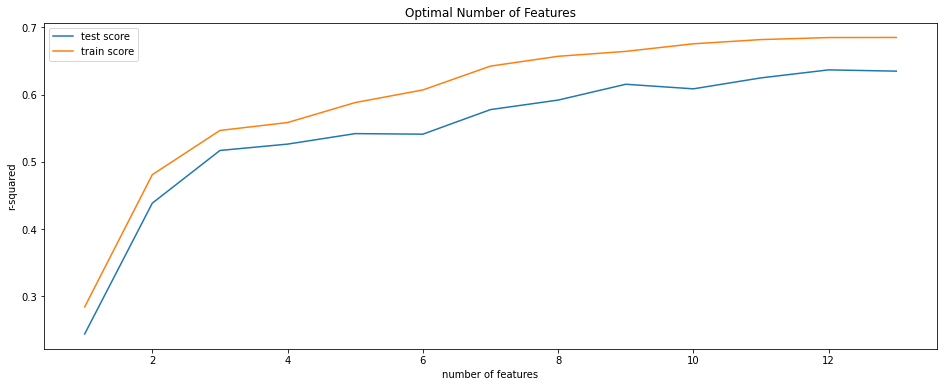

In [32]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

Ahora podemos elegir el valor óptimo de la cantidad de características y construir un modelo final.

In [33]:
# final model
n_features_optimal = 10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.599557533872853


Observe que el score de la prueba está muy cerca del 'score promedio de la prueba' en los k-fold (alrededor del 60%). En general, el score promedio estimado por  CV generalmente será un buen estimado del puntajescore de test.